<a href="https://colab.research.google.com/github/NataGoto/MNIST_recognition/blob/main/17_%D0%A3%D0%BB%D1%8C%D1%82%D1%80%D0%B0_cartoonset_%D0%92%D0%B0%D1%80%D0%B8%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D0%B0%D0%B2%D1%82%D0%BE%D0%BA%D0%BE%D0%B4%D0%B8%D1%80%D0%BE%D0%B2%D1%89%D0%B8%D0%BA%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Давайте немного отвлечемся от тяжелых будней будущего нейронщика и вспомним, что в мире есть маленькие радости - а именно мультяшки.

В этой работе:
- скачайте датасет от Гугла с мультяшными персонажами. Ссылка: https://storage.yandexcloud.net/aiueducation/Content/advanced/l1/cartoonset10k.zip
- обучите VAE на данном датасете
- посмотрите качество воспроизведения мультяшек
- нагенерите мультяшек на свой вкус - оцените работу декодера

In [ ]:
# загружаем датасет изображения (уменьшенные с 500 на 500 до 64 на 64, тк ПК не тянет). Ресайз не включен в ноутбук, он был на предыдущей итерации, после чего пришлось сделать рестарт ядра
import os
from PIL import Image
import numpy as np

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith('.png'):  # Добавляем проверку формата файла
            img = Image.open(os.path.join(folder, filename))
            if img is not None:
                images.append(np.array(img))  # Преобразуем изображение в массив numpy
    return images

# Загрузка тренировочных изображений
train_dir = "C:\\Users\\Admin\\Desktop\\Питон\\Вариационные_кодировщики\\cartoonset10k\\train"
train_images = load_images_from_folder(train_dir)

# Загрузка валидационных изображений
val_dir = "C:\\Users\\Admin\\Desktop\\Питон\\Вариационные_кодировщики\\cartoonset10k\\val"
val_images = load_images_from_folder(val_dir)

# Загрузка тестовых изображений
test_dir = "C:\\Users\\Admin\\Desktop\\Питон\\Вариационные_кодировщики\\cartoonset10k\\test"
test_images = load_images_from_folder(test_dir)


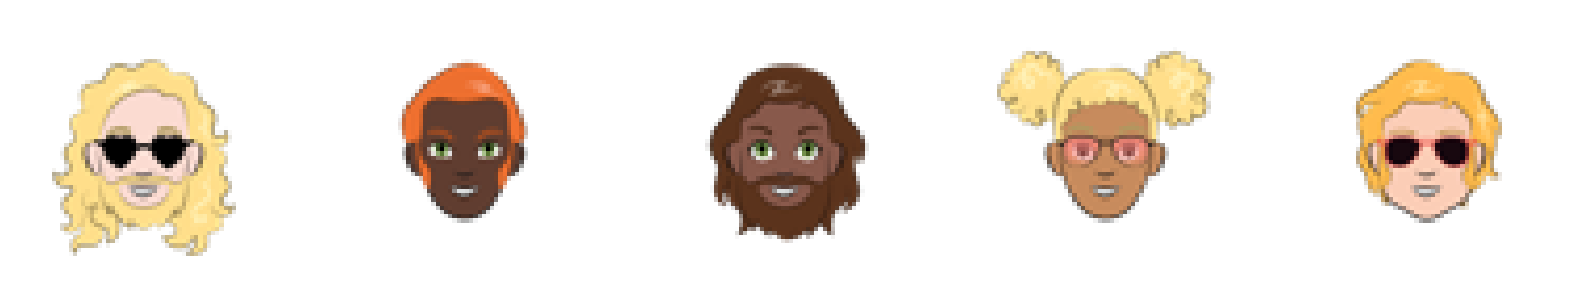

In [ ]:
# посмотрим побольше картинок
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 5, figsize=(20, 20))  # Создаем 5 подграфиков

for i in range(5):  # Проходим по первым 5 изображениям
    axs[i].imshow(train_images[i])  # Показываем i-тое изображение
    axs[i].axis('off')  # Отключаем оси для i-того подграфика

plt.show()


In [ ]:
# проверим сколько файлов в папках

def count_files_in_directory(directory):
    return len([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])

print("Количество файлов в тренировочной директории:", count_files_in_directory(train_dir))
print("Количество файлов в валидационной директории:", count_files_in_directory(val_dir))
print("Количество файлов в тестовой директории:", count_files_in_directory(test_dir))


Количество файлов в тренировочной директории: 12000
Количество файлов в валидационной директории: 4000
Количество файлов в тестовой директории: 4000


In [ ]:
# проверим, как выглядят метки
import pandas as pd
df = pd.read_csv(r'C:\Users\Admin\Desktop\Питон\Вариационные_кодировщики\cartoonset10k\train\cs10562124521050923.csv', header=None)
df.head()

,0,1,2
0,eye_angle,2,3
1,eye_lashes,1,2
2,eye_lid,1,2
3,chin_length,0,3
4,eyebrow_weight,0,2


In [ ]:
import os
import csv
from collections import defaultdict

def load_all_labels(folder_path):
    # Словари для хранения информации о классах и субклассах
    classes = defaultdict(int)
    subclasses = defaultdict(int)

    # Обработка каждого файла в папке
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            # Открытие файла
            with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as file:
                reader = csv.reader(file)
                # Добавление информации о классах и субклассах в словари
                for row in reader:
                    class_name = row[0]
                    subclass_value = int(row[1])
                    classes[class_name] += 1
                    subclasses[subclass_value] += 1

    return classes, subclasses

# Путь к папке с данными
data_folder_path = r'C:\Users\Admin\Desktop\Питон\Вариационные_кодировщики\cartoonset10k\train'

# Получение информации о классах и субклассах
classes_info, subclasses_info = load_all_labels(data_folder_path)

# Вывод информации о классах
print(f'Уникальные классы: {list(classes_info.keys())}')
print(f'Количество уникальных классов: {len(classes_info)}')

# Вывод информации о субклассах
print(f'Максимальное значение субкласса: {max(subclasses_info.keys())}')

Уникальные классы: ['eye_angle', 'eye_lashes', 'eye_lid', 'chin_length', 'eyebrow_weight', 'eyebrow_shape', 'eyebrow_thickness', 'face_shape', 'facial_hair', 'hair', 'eye_color', 'face_color', 'hair_color', 'glasses', 'glasses_color', 'eye_slant', 'eyebrow_width', 'eye_eyebrow_distance']
Количество уникальных классов: 18
Максимальное значение субкласса: 110


In [ ]:
import pandas as pd
import os

# Пути к файлам
file_paths = [
    "C:\\Users\\Admin\\Desktop\\Питон\\Вариационные_кодировщики\\cartoonset10k\\train_labels.csv",
    "C:\\Users\\Admin\\Desktop\\Питон\\Вариационные_кодировщики\\cartoonset10k\\test_labels.csv",
    "C:\\Users\\Admin\\Desktop\\Питон\\Вариационные_кодировщики\\cartoonset10k\\val_labels.csv"
]

# Создаем словарь
class_subclass_dict = {}

# Проходим по всем CSV-файлам
for file_path in file_paths:
    # Загружаем CSV-файл в DataFrame
    df = pd.read_csv(file_path)

    # Заполняем словарь
    class_subclass_set = set()
    for _, row in df.iterrows():
        class_subclass_tuple = (row.iloc[1], row.iloc[2], row.iloc[3])  # Используем колонки 1, 2 и 3 для класса и подклассов
        class_subclass_set.add(class_subclass_tuple)

    filename = os.path.basename(file_path)  # Получаем имя файла из пути
    class_subclass_dict[filename] = class_subclass_set

# Выводим словарь
for filename, class_subclass_set in class_subclass_dict.items():
    print(f"Файл: {filename}, Комбинации классов и подклассов: {list(class_subclass_set)[:5]}")


Файл: train_labels.csv, Комбинации классов и подклассов: [('hair_color', 5, 10), ('facial_hair', 11, 15), ('eyebrow_shape', 6, 14), ('hair', 27, 111), ('eyebrow_weight', 0, 2)]
Файл: test_labels.csv, Комбинации классов и подклассов: [('hair_color', 5, 10), ('eyebrow_shape', 6, 14), ('facial_hair', 11, 15), ('hair', 27, 111), ('eyebrow_weight', 0, 2)]
Файл: val_labels.csv, Комбинации классов и подклассов: [('hair_color', 5, 10), ('eyebrow_shape', 6, 14), ('facial_hair', 11, 15), ('hair', 27, 111), ('eyebrow_weight', 0, 2)]


In [ ]:
import pickle
# Сохраняем словарь в файл
with open(r'C:\Users\Admin\Desktop\Питон\Вариационные_кодировщики\cartoonset10k\class_subclass_dict.pkl', 'wb') as f:
    pickle.dump(class_subclass_dict, f)

print("Словарь сохранен в файл.")



Словарь сохранен в файл.


In [ ]:
# Создаем общее множество всех комбинаций
all_combinations = set()

# Проходим по всем записям словаря
for filename, class_subclasses in class_subclass_dict.items():
    # Добавляем комбинации в общее множество
    all_combinations.update(class_subclasses)

# Выводим общее количество уникальных комбинаций
print(f"Общее количество уникальных комбинаций классов и подклассов: {len(all_combinations)}")


Общее количество уникальных комбинаций классов и подклассов: 217


## Метки в датасете - неа каждое изображение приходится 18 классов +субкласс+субкласс, итого 18 классов и 36 меток в каждом csv файле.

In [ ]:
import tensorflow as tf
import keras

In [ ]:
# Подключим Numpy
import numpy as np

# Подключим библиотеку отображения графиков
import matplotlib.pyplot as plt

# Подключим датасет рукописных цифр MNIST
from tensorflow.keras.datasets import mnist

# Импортируем Keras
from tensorflow import keras

# Подключим все необходимые слои Keras
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Lambda, LeakyReLU
from tensorflow.keras.layers import BatchNormalization, Dropout, concatenate, Conv2D, Conv2DTranspose

# Подключим модуль вычислений на Keras
import keras.backend as K

# Подключим модуль работы с операционной системой
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # От tensorflow будет получать только ошибки

In [ ]:
import gc
gc.collect()

In [ ]:
# препроцессинг. Объявляем икс трейн
numclasses = 217

x_train = train_images
x_test = test_images
x_val = val_images

In [ ]:
#нормализуем изображения
x_train = np.array(x_train) / 255.0
x_val = np.array(x_val) / 255.0
x_test = np.array(x_test) / 255.0

In [ ]:
print(x_train.shape)
print(x_test.shape)

(6000, 64, 64, 4)
(2000, 64, 64, 4)


In [ ]:

# Замена альфа-канала на белый цвет и удаление альфа-канала
x_train = np.where(x_train[:, :, :, 3:4] != 0, x_train, 1)
x_val = np.where(x_val[:, :, :, 3:4] != 0, x_val, 1)
x_test = np.where(x_test[:, :, :, 3:4] != 0, x_test, 1)
x_train = x_train[:, :, :, :3]
x_val = x_val[:, :, :, :3]
x_test = x_test[:, :, :, :3]


In [ ]:
print(x_train.shape)
print(x_test.shape)

(6000, 64, 64, 3)
(2000, 64, 64, 3)


In [ ]:
# создаем список файлов

import os
train_filenames = [f for f in os.listdir("C:\\Users\\Admin\\Desktop\\Питон\\Вариационные_кодировщики\\cartoonset10k\\train") if f.endswith('.csv')]
val_filenames = [f for f in os.listdir("C:\\Users\\Admin\\Desktop\\Питон\\Вариационные_кодировщики\\cartoonset10k\\val") if f.endswith('.csv')]
test_filenames = [f for f in os.listdir("C:\\Users\\Admin\\Desktop\\Питон\\Вариационные_кодировщики\\cartoonset10k\\test") if f.endswith('.csv')]

In [ ]:
import pandas as pd

# Загрузим данные из файла
data = pd.read_csv("C:/Users/Admin/Desktop/Питон/Вариационные_кодировщики/cartoonset10k/train_labels.csv")

# Выведем первые 5 строк четвертой колонки
print(data.iloc[:5, 4])


0    cs10000592242416795426.csv
1    cs10000592242416795426.csv
2    cs10000592242416795426.csv
3    cs10000592242416795426.csv
4    cs10000592242416795426.csv
Name: filename, dtype: object


In [ ]:
# Делаем связку между словарем и именами файлов с комбинациями классов и подклассов
class_subclass_pairs = list(set([tuple(pair) for pairs in class_subclass_dict.values() for pair in pairs]))
class_subclass_to_index = {pair: i for i, pair in enumerate(class_subclass_pairs)}


In [ ]:
def get_class_subclass_index(class_subclass):
    return class_subclass_to_index[class_subclass]
#проверяем
# Выводим первую пару класс-подкласс из списка
first_class_subclass = class_subclass_pairs[0]
print(f"Первая пара класс-подкласс: {first_class_subclass}")

# Получаем и выводим соответствующий индекс
first_class_subclass_index = get_class_subclass_index(first_class_subclass)
print(f"Индекс первой пары класс-подкласс: {first_class_subclass_index}")

Первая пара класс-подкласс: ('hair_color', 5, 10)
Индекс первой пары класс-подкласс: 0


In [ ]:
# векторизуем наши классы
num_classes = 217  # Общее количество уникальных комбинаций классов и подклассов
num_classes_vector_size = num_classes # Размер вектора классов и подклассов

# Функция для создания вектора классов и подклассов для каждого файла
def create_classes_vector(filename, class_subclass_dict, num_classes):
    vector = np.zeros(num_classes)
    if filename in class_subclass_dict:
        for class_subclass in class_subclass_dict[filename]:
            # индекс комбинации класса и подкласса в векторе
            class_subclass_index = get_class_subclass_index(class_subclass)
            vector[class_subclass_index] = 1
    return vector

In [ ]:
# Для каждого изображения в тренировочном наборе мы используем словарь class_subclass_dict,
# чтобы найти соответствующие метки классов и подклассов. Затем мы преобразуем эти метки в вектор с помощью функции create_classes_vector.
# Результатом является список векторов y_train, где каждый вектор представляет метки классов и подклассов для одного изображения.
# Загрузим данные из файла
data = pd.read_csv("C:/Users/Admin/Desktop/Питон/Вариационные_кодировщики/cartoonset10k/train_labels.csv")

# Извлечем имена файлов
train_image_filenames = data['filename'].unique()  # используем unique(), чтобы удалить дубликаты

y_train = [create_classes_vector(filename, class_subclass_dict, num_classes) for filename in train_image_filenames]
# Загрузим данные из файла для валидационного набора
val_data = pd.read_csv("C:/Users/Admin/Desktop/Питон/Вариационные_кодировщики/cartoonset10k/val_labels.csv")

# Извлечем имена файлов
val_image_filenames = val_data['filename'].unique()  # используем unique(), чтобы удалить дубликаты

# список имен файлов нужен при создании векторов классов, так как у нас изображения икс трейн уже в массиве
y_val = [create_classes_vector(filename, class_subclass_dict, num_classes) for filename in val_image_filenames]

# Аналогично для тестового набора
test_data = pd.read_csv("C:/Users/Admin/Desktop/Питон/Вариационные_кодировщики/cartoonset10k/test_labels.csv")
test_image_filenames = test_data['filename'].unique()
y_test = [create_classes_vector(filename, class_subclass_dict, num_classes) for filename in test_image_filenames]


In [ ]:
print(len(y_train))
print(len(y_val))
print(len(y_test))
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

6000
2000
2000
(6000, 64, 64, 3)
(2000, 64, 64, 3)
(2000, 64, 64, 3)


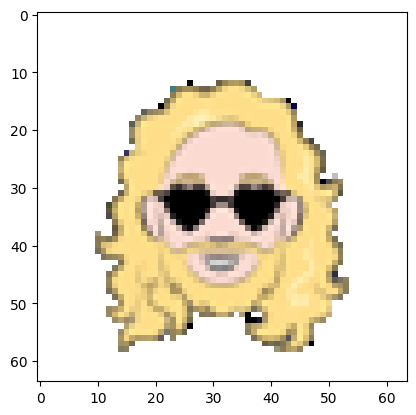

In [ ]:
#Очень интересно! На четвертом канале что-то есть! Вроде как он обычно же просто для каких-то прозрачностей.Так, а без четвертого канал что мы получим
#после распечатки мы видим, что 4 канал это, вероятно, фон (отображается инверси. После удаления 4го канала все выггядит нормально.
# выберем первое изображение
image = x_train[0]

# извлечем только RGB каналы
rgb_image = image[:, :, :3]

# визуализируем изображение
plt.imshow(rgb_image)
plt.show()


In [ ]:
print(type(x_train))
print(type(x_test))
print(type(y_train))
print(type(y_val))
print(type(y_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'list'>
<class 'list'>
<class 'list'>


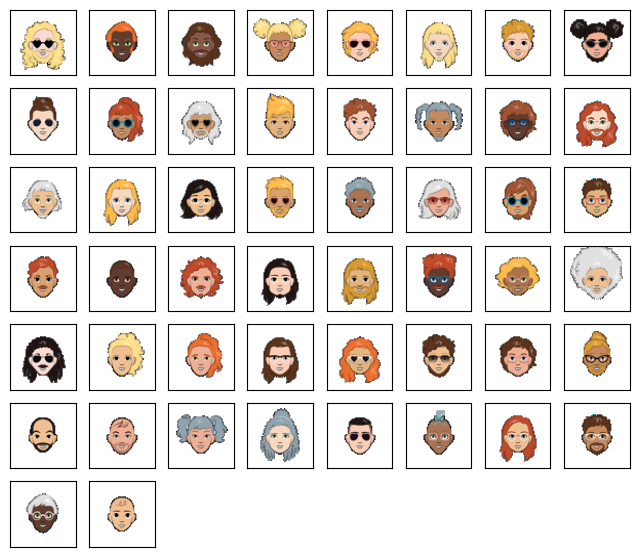

In [ ]:
# Создадим функцию вывод 50 элементов обучающей выборки

def showResult(viz):                                                  # Получим набор изображений

    total = 8                                                        # Полное количесво выводимых цифр
    plt.figure(figsize=(total, total))                                # Создаем заготовку для финальной картинки
    num = 1                                                           # Счетчик выводимых картинок
    for i in range(0, 50):                                           # Цикл по графикам
        ax = plt.subplot(total, total, num)                           # Добавим место для графика
        img = viz[num-1,:,:,:]                                        # Вывыбираем очередной график
        num += 1                                                      # Инкремент номера графика
        plt.imshow(img.squeeze())                                     # Рисуем предсказанную цифру
        ax.get_xaxis().set_visible(False)                             # Спрячем ось X
        ax.get_yaxis().set_visible(False)                             # Спрячем ось Y

# Взглянем на первые 20 изображений обучающей выборки

showResult(x_train[:50,:,:,:])

In [ ]:
# Скрытое пространство будет большое
latent_dim = 200

In [ ]:
# Функция создания блока энкодера-декодера

def dropout_and_batch(xin): # xin - входной тензор

  x = BatchNormalization()(xin) # Добавим слой нормализации
  x = Dropout(0.3)(x)           # Добавим дроаут

  # Вернем выходной тензор
  return x

In [ ]:
# Создадим функцию - генератор случайных чисел с заданными параметрами

def noiser(args):                                                          # Входные параметры
  z_mean, z_log_var = args                                                 # Разберем входные параметры на отдельные переменные
                                                                           # Эти "псевдовыходы" энкодера  потребуются для расчета потерь
  N = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.0) # Генерируем тензор из нормальных случайных  чисел с параметрами (0,1)

  # Вернем тензор случайных числел с заданной дисперсией и мат.ожиданием
  return K.exp(z_log_var / 2) * N + z_mean

h = Lambda(noiser, output_shape=(latent_dim,))([z_mean, z_log_var])        # Создадим свой слой - лямбда. На входе мат.ожидание и логарифм дисперсии
                                                                           # На выходе - тензор случайных чисел

In [ ]:
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.models import Model
import tensorflow as tf

def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [ ]:
# соберем энкодер
from keras import layers, models

# соберем энкодер
def encoder(input_shape, latent_dim):
    # Входной слой для изображения
    image_input = layers.Input(shape=input_shape, name='image_input')
    # Входной слой для классов
    class_input = layers.Input(shape=(217,), name='class_input')

    # Преобразуем class_input к размерности image_input
    class_dense = layers.Dense(units=np.prod(input_shape))(class_input)
    class_reshaped = layers.Reshape(input_shape)(class_dense)

    # Объединяем входы
    x = layers.Concatenate()([image_input, class_reshaped])

    # Block-1
    x = layers.Conv2D(32, kernel_size=3, strides=2, padding='same', name='conv_1')(x)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)

    # Block-2
    x = layers.Conv2D(64, kernel_size=3, strides=2, padding='same', name='conv_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)

    # Block-3
    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)

    # Block-4
    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.LeakyReLU(name='lrelu_4')(x)

    # Block-5
    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_5')(x)
    x = layers.BatchNormalization(name='bn_5')(x)
    x = layers.LeakyReLU(name='lrelu_5')(x)

    # Последний блок для вычисления z_mean, z_log_var и z
    flatten = layers.Flatten()(x)
    z_mean = layers.Dense(latent_dim, name='z_mean')(flatten)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(flatten)
    z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    # Создаем модель энкодера
    return models.Model([image_input, class_input], [z_mean, z_log_var, z], name='encoder')

# Задаем размерность входного изображения и размерность латентного пространства
input_shape = (64, 64, 3)
latent_dim = 200

# Создаем модель энкодера
encoder_model = encoder(input_shape, latent_dim)


In [ ]:
# Проверим состав энкодера
encoder_model.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 class_input (InputLayer)    [(None, 217)]                0         []                            
                                                                                                  
 dense_3 (Dense)             (None, 12288)                2678784   ['class_input[0][0]']         
                                                                                                  
 image_input (InputLayer)    [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 reshape_1 (Reshape)         (None, 64, 64, 3)            0         ['dense_3[0][0]']             
                                                                                            

In [ ]:
from tensorflow.keras import layers, Input
from tensorflow.keras.models import Model

# Создание декодера
def decoder(latent_dim):
    # Входной слой декодера
    decoder_input = Input(shape=(latent_dim,), name='decoder_input')

    # Преобразование вектора скрытого пространства в начальное состояние для сверточных слоев
    x = layers.Dense(8 * 8 * 64, name='dense_1')(decoder_input)
    x = layers.Reshape((8, 8, 64), name='Reshape')(x)

    # Block-1
    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', name='conv_transpose_1')(x)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)

    # Block-2
    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', name='conv_transpose_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)

    # Block-3
    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', name='conv_transpose_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)

    # Блок 4
    # Здесь должен быть шаг (stride) равный 1, чтобы размер выходного изображения оставался 64x64
    x = layers.Conv2DTranspose(64, 3, strides=1, padding='same', activation='relu', name='conv_transpose_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.LeakyReLU(name='lrelu_4')(x)

    # Блок 5
    outputs = layers.Conv2DTranspose(3, 3, strides=1, padding='same', activation='sigmoid', name='conv_transpose_last')(x)

    # Создание модели декодера
    decoder_model = Model(inputs=decoder_input, outputs=outputs, name='Decoder')

    return decoder_model

latent_dim = 200
decoder_model = decoder(latent_dim)
decoder_model.summary()



Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 200)]             0         
                                                                 
 dense_1 (Dense)             (None, 4096)              823296    
                                                                 
 Reshape (Reshape)           (None, 8, 8, 64)          0         
                                                                 
 conv_transpose_1 (Conv2DTr  (None, 16, 16, 64)        36928     
 anspose)                                                        
                                                                 
 bn_1 (BatchNormalization)   (None, 16, 16, 64)        256       
                                                                 
 lrelu_1 (LeakyReLU)         (None, 16, 16, 64)        0         
                                                           

In [ ]:
from keras import layers, models, losses, backend as K

# Задаем размерность входного изображения и размерность латентного пространства
input_shape = (64, 64, 3)
latent_dim = 200

# Входной слой для классов
class_input = layers.Input(shape=(217,), name='class_input')

# Создаем модель энкодера
encoder_model = encoder(input_shape, latent_dim)

# Входы модели VAE
vae_inputs = encoder_model.input  # encoder_model.input уже содержит image_input и class_input

# Выходы энкодера (z_mean, z_log_var, z)
encoder_outputs = encoder_model(vae_inputs)

# Выход декодера
decoder_outputs = decoder_model(encoder_outputs[2])

# Определение потерь восстановления
reconstruction_loss = losses.mean_squared_error(vae_inputs[0], decoder_outputs)
reconstruction_loss *= input_shape[0] * input_shape[1]  # Умножаем на размер изображения

# Определение потерь KL
z_mean, z_log_var = encoder_outputs[0], encoder_outputs[1]
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = -0.5 * K.sum(kl_loss, axis=-1)

# Общая функция потерь
cvae_loss = K.mean(reconstruction_loss) + K.mean(kl_loss)

# Создание модели VAE
cvae = models.Model(inputs=vae_inputs, outputs=decoder_outputs)

# Добавление функции потерь к модели
cvae.add_loss(cvae_loss)

# Компиляция модели VAE
cvae.compile(optimizer='adam')


In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(6000, 64, 64, 3)
(2000, 64, 64, 3)
(6000, 217)
(2000, 217)


In [ ]:
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)


In [ ]:
# Обучим модель
from keras.callbacks import ModelCheckpoint, CSVLogger

# Создаем колбэк для записи логов обучения
csv_logger = CSVLogger('training_log1.csv')

cvae.fit([x_train, y_train],  # Обучающая выборка + метки классов для энкодера и декодера
         x_train,                              # Обучающая выборка
         epochs=20,                            # Число эпох
         batch_size=16,                # Размер батча
         shuffle=True,
         callbacks=[csv_logger])

Epoch 1/20
375/375 [==============================] - 28s 71ms/step - loss: 115.3905
Epoch 2/20
375/375 [==============================] - 27s 71ms/step - loss: 81.4520
Epoch 3/20
375/375 [==============================] - 26s 70ms/step - loss: 74.6070
Epoch 4/20
375/375 [==============================] - 27s 72ms/step - loss: 68.9499
Epoch 5/20
375/375 [==============================] - 28s 76ms/step - loss: 63.1060
Epoch 6/20
375/375 [==============================] - 28s 73ms/step - loss: 59.9284
Epoch 7/20
375/375 [==============================] - 29s 76ms/step - loss: 56.1791
Epoch 8/20
375/375 [==============================] - 29s 78ms/step - loss: 53.7438
Epoch 9/20
375/375 [==============================] - 30s 79ms/step - loss: 51.4543
Epoch 10/20
375/375 [==============================] - 29s 78ms/step - loss: 49.8322
Epoch 11/20
375/375 [==============================] - 28s 76ms/step - loss: 48.6184
Epoch 12/20
375/375 [==============================] - 28s 75ms/step - lo

In [ ]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

# Если y_train - это список массивов, проверьте размер каждого массива
if isinstance(y_train, list):
    for i, y in enumerate(y_train):
        print(f"y_train[{i}] shape:", y.shape)


x_train shape: (6000, 64, 64, 3)
y_train shape: (6000, 217)


In [ ]:
#  x_test - это новые изображения, а y_test - соответствующие векторы классов
predicted_images = cvae.predict([x_test, y_test])


63/63 [==============================] - 3s 46ms/step


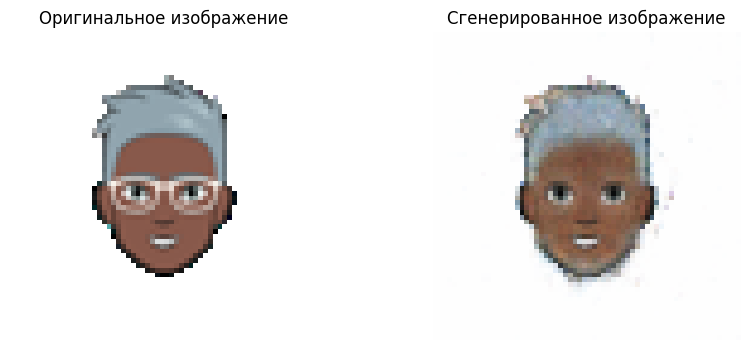

In [ ]:
import matplotlib.pyplot as plt

# Выберем случайное изображение для демонстрации
index = np.random.randint(0, len(x_test))
plt.figure(figsize=(10, 4))

# Отображаем оригинальное изображение
plt.subplot(1, 2, 1)
plt.imshow(x_test[index])
plt.title("Оригинальное изображение")
plt.axis('off')

# Отображаем сгенерированное изображение
plt.subplot(1, 2, 2)
plt.imshow(predicted_images[index])
plt.title("Сгенерированное изображение")
plt.axis('off')

plt.show()


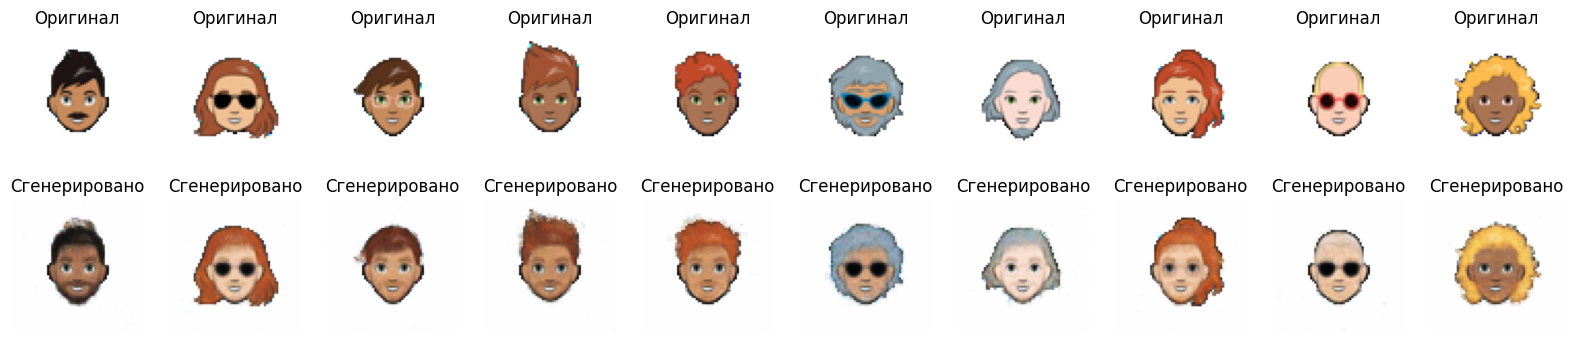

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Интересно, что у нас восстановилось лицо без очков. Попробуем больше картинок

# Устанавливаем количество изображений для отображения
num_images = 10

# Выбираем случайные индексы для демонстрации
indices = np.random.choice(len(x_test), num_images, replace=False)

# Создаем фигуру для отображения изображений
plt.figure(figsize=(20, 4))

for i, index in enumerate(indices):
    # Отображаем оригинальное изображение
    plt.subplot(2, num_images, i + 1)
    plt.imshow(x_test[index])
    plt.title("Оригинал")
    plt.axis('off')

    # Отображаем сгенерированное изображение
    plt.subplot(2, num_images, i + 1 + num_images)
    plt.imshow(predicted_images[index])
    plt.title("Сгенерировано")
    plt.axis('off')

# Показываем изображения
plt.show()


## Мы восстановили неплохо, но потеряли у одного лица бороду, у двух лиц цвет оправы очков.

In [ ]:
cvae.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 class_input (InputLayer)    [(None, 217)]                0         []                            
                                                                                                  
 encoder (Functional)        [(None, 200),                2913776   ['image_input[0][0]',         
                              (None, 200),                           'class_input[0][0]']         
                              (None, 200)]                                                        
                                                                                            

1/1 [==============================] - 0s 104ms/step


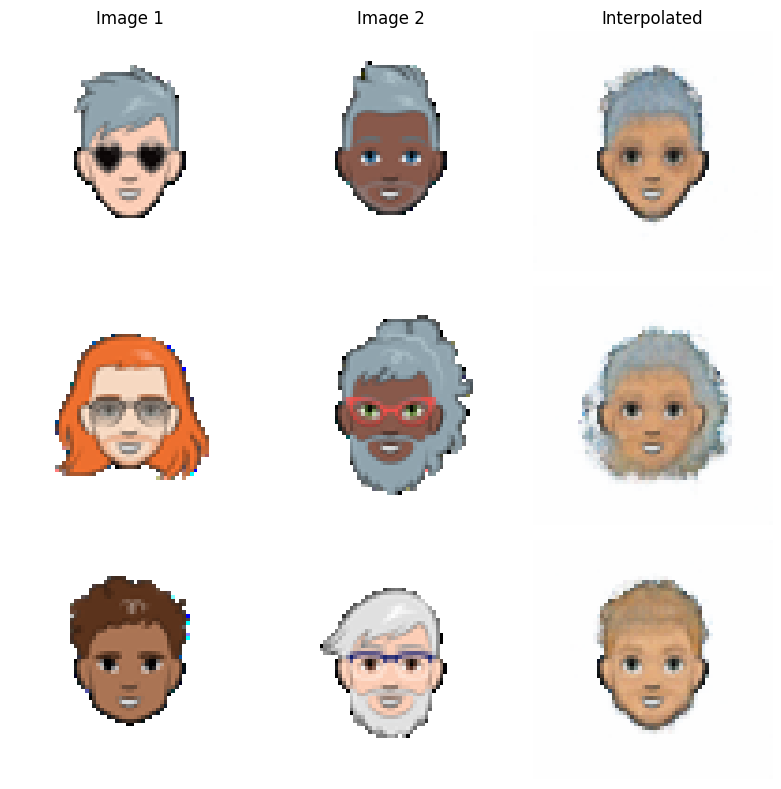

In [ ]:
# интерполяция (сборка смешанных атрибутов двух картинок в третьей)
import numpy as np
import matplotlib.pyplot as plt
import random
from keras import backend as K

def reparameterize(mean, log_var):
    eps = K.random_normal(shape=K.shape(mean))
    return mean + K.exp(log_var / 2) * eps

# Выбираем случайные изображения из x_test
indices_1 = np.random.choice(len(x_test), size=3, replace=False)
indices_2 = np.random.choice(len(x_test), size=3, replace=False)

imgs_1 = x_test[indices_1]
imgs_2 = x_test[indices_2]

# Кодируем изображения

means_1, logvars_1, _ = encoder_model.predict([imgs_1, y_test[indices_1]])
means_2, logvars_2, _ = encoder_model.predict([imgs_2, y_test[indices_2]])


# Репараметризация для получения скрытых векторов
params_1 = reparameterize(means_1, logvars_1)
params_2 = reparameterize(means_2, logvars_2)

# Интерполяция между скрытыми векторами
params = (params_1 + params_2) / 2

# Декодирование интерполированных скрытых векторов обратно в изображения
interpolated_imgs = decoder_model.predict(params)

# Визуализация
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
titles = ['Image 1', 'Image 2', 'Interpolated']

for ax, col in zip(axs[0], titles):
    ax.set_title(col)

for i in range(3):
    axs[i, 0].imshow(imgs_1[i])
    axs[i, 1].imshow(imgs_2[i])
    axs[i, 2].imshow(interpolated_imgs[i])

for ax in axs.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()
